# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * 1-dimensional convolutions for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part.

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on job salary prediction
![img](http://www.kdnuggets.com/images/cartoon-data-scientist-salary-negotiation.gif)

Original conest - https://www.kaggle.com/c/job-salary-prediction


### Download
Go [here](https://www.kaggle.com/c/job-salary-prediction) and download as usual

CSC cloud: data should already be here somewhere, just poke the nearest instructor.




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Categorical fields - contract type, location

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [7]:
df = pd.read_csv("./Train_rev1.csv",sep=',')

In [16]:
print df.shape, df.SalaryNormalized.mean()
df[:5]

 (244768, 12) 34122.5775755


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [18]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.FullDescription.values,df.Title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

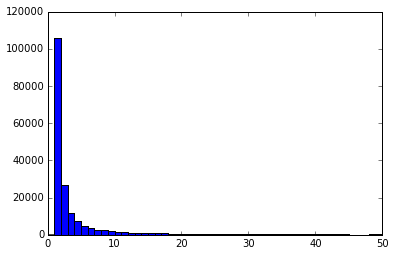

In [19]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [23]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 5
tokens = <tokens from token_counts keys that had at least min_count occurences throughout the dataset>


In [24]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [25]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 10000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 100000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 44867


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [34]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [35]:
desc_tokens = vectorize(df.FullDescription.values,token_to_id,max_len = 500)
title_tokens = vectorize(df.Title.values,token_to_id,max_len = 15)

### Data format examples


In [36]:
print "Matrix size:",title_tokens.shape
for title, tokens in zip(df.Title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (244768, 15)
Engineering Systems Analyst -> [38462 12311  1632     0     0     0     0     0     0     0] ...
Stress Engineer Glasgow -> [19749 41620  5861     0     0     0     0     0     0     0] ...
Modelling and simulation analyst -> [23387 16330 32144  1632     0     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are categorical data. E.g. location, contract type, company

They require a separate preprocessing step.

In [ ]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat = df[["Category","LocationNormalized","ContractType","ContractTime"]]


categories = [A list of dictionaries {"category":category_name, "subcategory":subcategory_name} for each data sample]

    

vectorizer = DictVectorizer(sparse=False)
df_non_text = vectorizer.fit_transform(categories)
df_non_text = pd.DataFrame(df_non_text,columns=vectorizer.feature_names_)




# Split data into training and test

In [ ]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')
#Non-sequences
df_non_text = df_non_text.astype('float32')

In [ ]:

#Split into training and test set.


#Difficulty selector:
#Easy: split randomly
#Medium: split by companies, make sure no company is in both train and test set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = <define_these_variables>



## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [ ]:

save_prepared_data = True #save
read_prepared_data = False #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)


if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "done"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)


        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

        
    print "done"
        

# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles
 * cnn+global max or RNN
* Separate input for description
 * cnn+global max or RNN
* Separate input for categorical features
 * Few dense layers + some black magic if you want
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple regression task 

In [1]:
#libraries
import lasagne
from theano import tensor as T
import theano

/usr/local/lib/python2.7/dist-packages/Theano-0.8.0rc1-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [ ]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.vector("is_blocked",dtype='float32')

# NN architecture

In [ ]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)


In [ ]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.

descr_nn = lasagne.layers.EmbeddingLayer(descr_inp,
                                         input_size=len(token_to_id)+1,
                                         output_size=?)


#reshape from [batch, time, unit] to [batch,unit,time] to allow 1d convolution over time
descr_nn = lasagne.layers.DimshuffleLayer(descr_nn, [0,2,1])

descr_nn = 1D convolution over embedding, maybe several ones in a stack

#pool over time
descr_nn = lasagne.layers.GlobalPoolLayer(descr_nn,T.max)

#Possible improvements here are adding several parallel convs with different filter sizes or stacking them the usual way
#1dconv -> 1d max pool ->1dconv and finally global pool 


# Titles
title_nn = <Process titles somehow (title_inp)>

# Non-sequences
cat_nn = <Process non-sequences(cat_inp)>


In [ ]:
nn = <merge three layers into one (e.g. lasagne.layers.concat) >                                  

nn = lasagne.layers.DenseLayer(nn,your_lucky_number)
nn = lasagne.layers.DropoutLayer(nn,p=maybe_use_me)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 


In [ ]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [ ]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#loss function
loss = lasagne.objectives.squared_error(prediction,target_y).mean()



In [ ]:
#Weight optimization step
updates = <your favorite optimizer>

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [ ]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = <an excercise in copy-pasting and editing>


### Coffee-lation

In [ ]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [ ]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]
        


### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump up and down for several epochs

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error


n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100


for i in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\trmse:',mean_squared_error(epoch_y_true,epoch_y_pred)**.5
    print '\tmae:',mean_absolute_error(epoch_y_true,epoch_y_pred)
    
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\trmse:',mean_squared_error(epoch_y_true,epoch_y_pred)**.5
    print '\tmae:',mean_absolute_error(epoch_y_true,epoch_y_pred)


In [2]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. 


# Final evaluation
Evaluate network over the entire test set

In [ ]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\trmse:',mean_squared_error(epoch_y_true,epoch_y_pred)**.5
print '\tmae:',mean_absolute_error(epoch_y_true,epoch_y_pred)

Now tune the monster for least MSE you can get!

# Next time in our show
* Recurrent neural networks
 * How to apply them to practical problems?
 * What else can they do?
 * Why so much hype around LSTM?
* Stay tuned!